In [69]:
#Import statements
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from lppy import locproj


order: [2] and [3]
[0.56582101 0.07513178 2.2038993 ]
order: [2] and [4]
[0.87153168 0.17734144 1.85765347]
order: [1] and [3]
[0.84285651 0.50037057 1.57556872]
order: [2] and [2]
order: [1] and [4]
[ 0.98072899 -0.06208206  2.7003003 ]


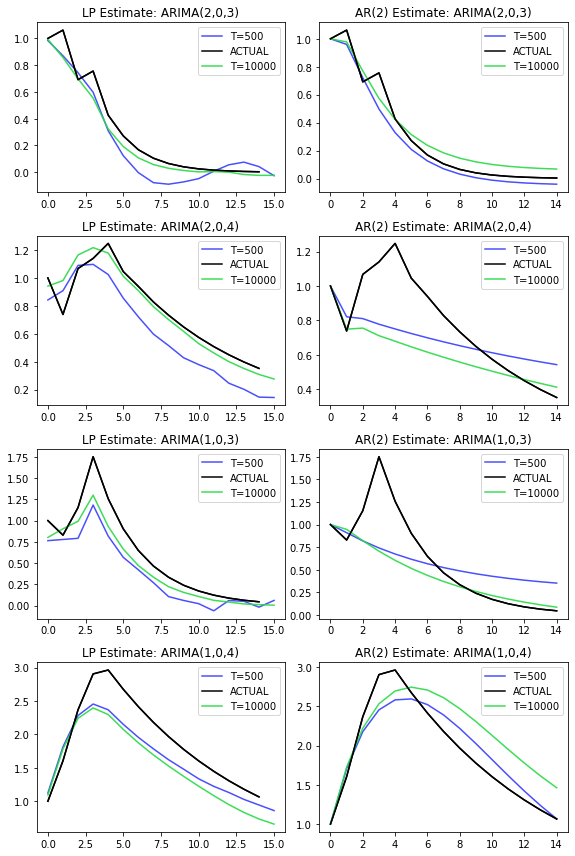

In [72]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

#Goals for the unknown parameters
#take lists of vector length, 1 and 0 etc
#with vector length in hand, its time to generate the DGP
#After this point you can simulate the data and then you need something to compare it to 
#shows the estimate for different numbers of samples

from statsmodels.tsa.ar_model import *
import seaborn as sns 
#sns.set()
fig, axs = plt.subplots(4,2)
plt.rcParams['figure.figsize'] = [8, 12]
plt.tight_layout

i = 0
AR_lag_l = 2

while i < 4:
    try:

        
        rng = np.random.default_rng()
        p = rng.integers(low=1, high=3, size=1)
        q = rng.integers(low=2, high=5, size=1)
        print(f"order: {p} and {q}")
        
        arparams = np.random.rand(p[0],1)
        maparams = np.random.rand(q[0],1)
        
        ar = np.r_[1, -arparams[:,0]] # add zero-lag and negate
        ma = np.r_[1, maparams[:,0]] # add zero-lag
        param_vec = np.r_[ar,ma]
        arma_process = sm.tsa.ArmaProcess(ar, ma)
        if arma_process.isstationary ==False:
                continue
            
        y = arma_process.generate_sample(10000)
        model = sm.tsa.ARIMA(y,exog=None, order= (p, 0, q), trend='n').fit()
        print(model.params)
        #model = sm.tsa.ARIMA(y,exog=None, order= (p, 0, q), trend='n').fit(start_params=param_vec)
        #Need to find the structural shock
        residual = y - model.fittedvalues

        
        ss_vec = {500:"#353cfc", 10000:"#27d945"}
        
        color_idx =0
        for ss in ss_vec:
            
            
            armodel = AutoReg(y[0:ss],lags=AR_lag_l).fit()
            #print(armodel.params)
            ar_fcast = np.zeros(15)
            last_vals = np.zeros(AR_lag_l)
            last_vals[0] = 1
            ar_fcast[0] =1
            for tstep in range(1,15):
                resp = sum(armodel.params * [1, *last_vals])
                ar_fcast[tstep] = resp
                last_vals[1:AR_lag_l] = last_vals[0:(AR_lag_l-1)] 
                last_vals[0] = resp
                
                
            #ar_fcast = armodel.predict(ss,ss+15)
            
            irf = locproj(residual[0:ss],y[0:ss],0,15,99)
            
            #Define plots here 
            axs[i,0].plot(irf.resp,color = ss_vec[ss] ,alpha = .9,label = f"T={ss}")
            axs[i,0].legend()
            axs[i,0].set_title(f"LP Estimate: ARIMA({p[0]},0,{q[0]})")
            axs[i,0].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            
            axs[i,1].plot(ar_fcast,color = ss_vec[ss],alpha = .9,label = f"T={ss}")
            axs[i,1].legend()
            axs[i,1].set_title(f"AR({AR_lag_l}) Estimate: ARIMA({p[0]},0,{q[0]})")
            axs[i,1].plot(arma_process.impulse_response(15),color='black',label='ACTUAL')
            
            color_idx += 1
        
           
        # axs[i,0].legend(loc='upper center')
        # axs[i,1].legend(loc='upper center')
        i +=1
    except:
        print("failed this loop")


    
